In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import pickle
import torch
import astropy.units as u

from typing import Tuple, Optional, Union
from itertools import cycle
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle, concatenate
from sklearn.model_selection import train_test_split
from neural_net import normalize_arr, get_model, CustomLoss, resume
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, accuracy_score
from sklearn.impute import KNNImputer
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import StandardScaler
from corner import corner

from preprocessing.preprocessing import ab_mag_to_flux
from SPLASH.pipeline import Splash_Pipeline
ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux

import matplotlib as mpl
plt.rc('text', usetex=True)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

Helper functions

In [2]:
def normalize_arr(arr: np.ndarray, errors: np.ndarray = None, axis: int = 0, mean: float = None, std: float = None) -> (float, float, float, Optional[np.ndarray]):
    """Normalize numpy array along given axis and its errors if given."""
    if mean is None:
        mean = np.mean(arr, axis=axis, keepdims=True)
    if std is None:
        std = np.std(arr, axis=axis, keepdims=True)
    if not errors is None:
        return (arr - mean) / std, mean[0], std[0], errors / std
    else:
        return (arr - mean) / std, mean, std

In [3]:
zou_pipeline = Splash_Pipeline(pipeline_version='weighted_full_band', pre_transformed=True, within_4sigma=False)
pstar_pipeline = Splash_Pipeline(pipeline_version='weighted_full_band', pre_transformed=True, within_4sigma=False)
yse_bts_pipeline = Splash_Pipeline(pipeline_version='weighted_full_band', pre_transformed=True, within_4sigma=False)

In [4]:
# Also grab the means and std of the host properties
from host_prop_nn import load_and_preprocess
test, _, photo_train, photo_test, cat_train, cat_test, _, _, _, _, _, hprop_photo_means, hprop_photo_std, _, _, prop_mean, prop_std, _ = load_and_preprocess()

# Get the mean and std of the training set
from sed_nn import load_and_preprocess
_, _, _, _, _, _, _, _, _, photo_mean, photo_std, photo_err_norm = load_and_preprocess()

2024-05-11 18:43:59,633 - host_prop_nn.py - INFO - Importing photometry data
2024-05-11 18:44:02,815 - host_prop_nn.py - INFO - Fixing the error for 96514 objects
2024-05-11 18:44:02,834 - host_prop_nn.py - INFO - Importing photometry data
2024-05-11 18:44:05,103 - host_prop_nn.py - INFO - Photo stats:
 	mean = [-2.87849839 -2.79518071 -2.78359176 -2.63765973 -2.66592091 -1.33953981
  0.06383305  0.67075717  1.34771103  0.91141463  1.33652476  1.2116005
  1.32755404 -2.41376848 -2.20197162 -1.97797089 -3.03436027 -3.03643454]
 	std = [0.63162979 0.70187988 0.68387317 0.72578209 0.7777774  0.88136263
 1.62222597 2.06392269 0.43210206 1.36265575 0.50050502 0.43821229
 0.46058673 2.21595863 2.13270738 2.02278681 0.67246779 0.70040306]
2024-05-11 18:44:05,106 - host_prop_nn.py - INFO - Catalog stats:
 	mean = [ 8.87088133 -0.46037044  0.58991822]
 	std = [1.08494612 1.04024203 0.2700682 ]
2024-05-11 18:44:05,108 - host_prop_nn.py - INFO - Length = 1200550


HEEERRRREE [[ 0.69879328  1.44090157  0.141008  ]
 [-0.5611702   0.68871811  0.84083122]
 [-0.49142539  0.80762344  0.5149876 ]
 ...
 [ 0.56822286 -1.04936127  0.70753156]
 [-1.45187574 -0.5911653  -0.31813528]
 [-0.55335552 -0.57962198 -0.99574189]]
[ 8.87088133 -0.46037044  0.58991822]


2024-05-11 18:44:05,877 - sed_nn.py - INFO - Importing photometry data
2024-05-11 18:44:07,718 - sed_nn.py - INFO - Fixing the error for 96514 objects
2024-05-11 18:44:07,730 - sed_nn.py - INFO - Importing photometry data
2024-05-11 18:44:09,367 - sed_nn.py - INFO - Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
2024-05-11 18:44:09,370 - sed_nn.py - INFO - Catalog stats:
 	mean = [[ 8.69840122 -0.65829206  0.56184221]]
 	std = [[1.31209275 1.35189867 0.29137484]]
2024-05-11 18:44:09,371 - sed_nn.py - INFO - Length = 1261630


HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[[ 8.69840122 -0.65829206  0.56184221]]


2024-05-11 18:44:10,326 - sed_nn.py - INFO - Splitting into:
	X = ['G', 'R', 'I', 'Z', 'Y']
	y = ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']


# Get PanSTARR, Zhou, and YSE/BTS host properties

## YSE+BTS

In [5]:
# BTS
bts_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/bts_hosts.ecsv')
bts_df = bts_hosts.to_pandas()

# YSE
yse_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/yse_hosts.ecsv')
yse_df = yse_hosts.to_pandas()
print('BTS keys: ', bts_df.columns)
print('YSE keys: ', yse_df.columns)

BTS keys:  Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'sn_class', 'sn_redshift', 'ZTFID'],
      dtype='object')
YSE keys:  Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'sn_class', 'sn_redshift'],
      dtype='object')


In [6]:
# Function to calculate angular separation
def get_angular_separation(ra1, dec1, ra2, dec2, unit1='deg', unit2='arcsec'):
    coord1 = SkyCoord(ra1, dec1, unit=unit1)
    coord2 = SkyCoord(ra2, dec2, unit=unit2)
    return coord1.separation(coord2).arcsec


def propocess_tab(table: ascii.Tab) -> pd.DataFrame:

    # Make and format a pd dataframe
    df: pd.DataFrame = table.to_pandas()
    column_types = {col: float for col in df.columns[:-2]}
    column_types[df.columns[-2]] = str
    column_types[df.columns[-1]] = float
    df = df.astype(column_types)
    df.replace('nan', np.nan, inplace=True)

    # The columns of grizy mags
    sed_cols = ['gKronMag_3pi','rKronMag_3pi','iKronMag_3pi','zKronMag_3pi','yKronMag_3pi']

    # Drop rows where the specified columns have more than 4 NaN values
    orig_len = len(df)
    df = df.dropna(thresh=3, subset=sed_cols, ignore_index=True)
    df = df.dropna(subset=['sn_class'], ignore_index=True)
    print(f'Dropped {orig_len - len(df)}/{orig_len} rows due to missingness. Now have {len(df)}')

    # Apply the function to each row
    df['angular_separation_arcsec'] = df.apply(lambda row: get_angular_separation(row['raStack_3pi'], row['decStack_3pi'], row['SN_ra'], row['SN_dec'], unit1='deg', unit2='deg'), axis=1)

    return df

In [7]:
types_all = pd.concat((bts_df['sn_class'], yse_df['sn_class'])).astype(str)
sn_mask = np.array(['sn' in item.lower() for item in types_all.astype(str)])
np.unique(types_all[sn_mask])

array(['SLSN-I', 'SLSN-II', 'SN II', 'SN II-pec', 'SN IIP', 'SN IIb',
       'SN IIn', 'SN Ia', 'SN Ia-91T', 'SN Ia-91bg', 'SN Ia-CSM',
       'SN Ia-SC', 'SN Ia-pec', 'SN Iax', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
       'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Ic-pec', 'SN Icn', 'SNII',
       'SNIIb', 'SNIIn', 'SNIa-91T-like', 'SNIa-91bg-like', 'SNIa-CSM',
       'SNIa-SC', 'SNIa-norm', 'SNIax', 'SNIb', 'SNIb-pec', 'SNIbn',
       'SNIc', 'SNIc-BL'], dtype=object)

In [8]:
# Get the angular separations of everything
coords_all = pd.concat((bts_df[['SN_ra', 'SN_dec', 'raStack_3pi', 'decStack_3pi']], yse_df[['SN_ra', 'SN_dec', 'raStack_3pi', 'decStack_3pi']])).astype(float)
sn_coords = SkyCoord(ra=coords_all['SN_ra'].values*u.degree, dec=coords_all['SN_dec'].values*u.degree, frame='icrs')
stack_coords = SkyCoord(ra=coords_all['raStack_3pi'].values*u.degree, dec=coords_all['decStack_3pi'].values*u.degree, frame='icrs')
angular_separation = sn_coords.separation(stack_coords).arcsecond
coords_all['angular_separation_arcsec'] = angular_separation

In [9]:
# Compile all data into one array
grizy_keys = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
X_all = pd.concat((bts_df[grizy_keys], yse_df[grizy_keys])).astype(float)
z_all = pd.concat((bts_df['sn_redshift'], yse_df['sn_redshift'])).astype(float)
grizy_err_keys = ['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi', 'zKronMagErr_3pi', 'yKronMagErr_3pi']
X_all_err = pd.concat((bts_df[grizy_err_keys], yse_df[grizy_err_keys])).astype(float)

# Drop all the rows where we don't have at least 3 grizy bands
bad_rows_mask = X_all.isnull().sum(axis=1) >= 1
good_rows_mask = (~bad_rows_mask) & sn_mask
X_all = X_all[good_rows_mask].to_numpy()
z_all = z_all[good_rows_mask].to_numpy()
X_all_err = X_all_err[good_rows_mask].to_numpy()
types_all = types_all[good_rows_mask].to_numpy()
angular_separation = angular_separation[good_rows_mask]

# Convert grizy from mag to flux and take the log
X_all = ab_mag_to_flux(X_all)
X_all_err = ab_magerr_to_ferr(X_all_err, X_all)
imputer = KNNImputer(n_neighbors=5)
X_all = imputer.fit_transform(X_all)
X_all = np.log10(X_all)

In [10]:
# Call the yse and bts data
X_all_norm, X_mean, X_std = normalize_arr(X_all, mean=photo_mean[:5], std=photo_std[:5])
X_all_norm_err = X_all_err / photo_std[:5]

In [11]:
# within_good_range = np.all((X_all_norm < 4) & (X_all_norm > -4), axis=1)
within_good_range = np.array([True for _ in range(len(z_all))])
X_all_norm, X_all_norm_err, z_all = X_all_norm[within_good_range], X_all_norm_err[within_good_range], z_all[within_good_range]

In [12]:
# Get props
bts_yse_props = yse_bts_pipeline.predict_host_properties(X_all_norm, X_all_norm_err, return_normalized=True, n_resamples=50) * prop_std + prop_mean

# Add the angular separation to the host props
bts_yse_props = np.hstack((np.atleast_2d(angular_separation).reshape(-1,1), bts_yse_props))

## Zou

In [13]:
zou_df = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/classified_zou_hosts_pcc.csv')
zou_df = zou_df.iloc[:, 1:]
print(zou_df.keys())
zou_df.head()

Index(['gal_id', 'host_ra', 'host_dec', 'SN_ra', 'SN_dec', 'SN_class', 'G',
       'G_err', 'R', 'R_err', 'I', 'I_err', 'Z', 'Z_err', 'Y', 'Y_err', 'J',
       'J_err', 'H', 'H_err', 'Ks', 'Ks_err', 'CH1', 'CH1_err', 'CH2',
       'CH2_err', 'MIPS24', 'MIPS24_err', 'MIPS70', 'MIPS70_err', 'PACS100',
       'PACS100_err', 'MIPS160', 'MIPS160_err', 'PACS160', 'PACS160_err',
       'SPIRE250', 'SPIRE250_err', 'SPIRE350', 'SPIRE350_err', 'SPIRE500',
       'SPIRE500_err', 'log_Mstar_best', 'log_Mstar_best_err', 'log_SFR_best',
       'log_SFR_best_err', 'redshift', 'redshift_err'],
      dtype='object')


,gal_id,host_ra,host_dec,SN_ra,SN_dec,SN_class,G,G_err,R,R_err,...,SPIRE350,SPIRE350_err,SPIRE500,SPIRE500_err,log_Mstar_best,log_Mstar_best_err,log_SFR_best,log_SFR_best_err,redshift,redshift_err
0,793720,53.502701,-28.660248,192609.75,-103176.8,Ia,0.000709,0.000083,0.000768,0.000155,...,0.000289,0.000049,0.000076,0.000046,9.136305,0.229359,-1.395027,1.212359,0.612,0.1585
1,1387864,53.267826,-26.964813,191760.15,-97073.5,Ic,1.890661,0.171436,2.359364,0.213790,...,0.000476,768648.315996,0.784934,0.072928,9.792891,0.130438,0.329521,0.066791,0.060,0.0100
2,776283,54.172970,-27.840040,195021.00,-100224.0,Ia,0.003090,0.000283,0.003418,0.000330,...,0.001066,0.000100,0.001962,0.000187,8.377576,0.136285,-0.975580,0.154471,0.219,0.0100
3,806358,53.526012,-27.632126,192693.30,-99475.6,"Ia,Ia-91T",0.181993,0.016444,0.179727,0.016241,...,0.093501,0.008449,0.070639,0.006514,10.261489,0.097379,-2.026393,1.087790,0.148,0.0100
4,1176629,53.912155,-28.319046,194081.25,-101949.6,Ia,0.027983,0.002538,0.034696,0.003164,...,0.018753,0.001710,0.006656,0.000626,10.256422,0.133721,0.147166,0.192132,0.382,0.0100


In [14]:
# Add angular separation
zou_df['angular_separation_arcsec'] = get_angular_separation(zou_df['host_ra'], zou_df['host_dec'], zou_df['SN_ra'], zou_df['SN_dec'])
zou_df

,gal_id,host_ra,host_dec,SN_ra,SN_dec,SN_class,G,G_err,R,R_err,...,SPIRE350_err,SPIRE500,SPIRE500_err,log_Mstar_best,log_Mstar_best_err,log_SFR_best,log_SFR_best_err,redshift,redshift_err,angular_separation_arcsec
0,793720,53.502701,-28.660248,192609.75,-103176.8,Ia,0.000709,0.000083,0.000768,0.000155,...,0.000049,0.000076,0.000046,9.136305,0.229359,-1.395027,1.212359,0.6120,0.1585,0.095110
1,1387864,53.267826,-26.964813,191760.15,-97073.5,Ic,1.890661,0.171436,2.359364,0.213790,...,768648.315996,0.784934,0.072928,9.792891,0.130438,0.329521,0.066791,0.0600,0.0100,3.590571
2,776283,54.172970,-27.840040,195021.00,-100224.0,Ia,0.003090,0.000283,0.003418,0.000330,...,0.000100,0.001962,0.000187,8.377576,0.136285,-0.975580,0.154471,0.2190,0.0100,1.502568
3,806358,53.526012,-27.632126,192693.30,-99475.6,"Ia,Ia-91T",0.181993,0.016444,0.179727,0.016241,...,0.008449,0.070639,0.006514,10.261489,0.097379,-2.026393,1.087790,0.1480,0.0100,0.309975
4,1176629,53.912155,-28.319046,194081.25,-101949.6,Ia,0.027983,0.002538,0.034696,0.003164,...,0.001710,0.006656,0.000626,10.256422,0.133721,0.147166,0.192132,0.3820,0.0100,2.438545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,1956182,36.351833,-4.313780,130866.60,-15529.3,Ia,0.001830,0.000180,0.002001,0.000200,...,0.000087,0.001322,0.000133,9.373738,0.164706,0.084039,0.225938,0.7290,0.1110,0.309108
297,1825846,36.713257,-4.788411,132169.05,-17238.3,Ia,0.028377,0.002567,0.047304,0.004278,...,0.001492,0.024302,0.002217,11.225169,0.095835,1.198637,0.147773,0.8864,0.0100,1.320941
298,1774928,36.311970,-4.927190,130721.55,-17739.8,Ia,0.020145,0.001823,0.020419,0.001851,...,0.001627,0.017365,0.001590,8.956316,0.194562,-0.979513,0.256470,0.1730,0.0715,2.454468
299,2038263,36.904522,-4.050773,132856.95,-14582.6,"Ia,Ia?",0.009049,0.000829,0.011145,0.001024,...,0.000632,0.008149,0.000803,9.837953,0.162529,0.270586,0.256250,0.5040,0.0870,0.693530


In [15]:
prop_keys = ['angular_separation_arcsec', 'log_Mstar_best', 'log_SFR_best', 'redshift']
zou_props = zou_df[prop_keys].to_numpy()

## PanSTARRS

In [16]:
# Get the preprocessed pstar data
panstarr_tab = ascii.read("/Users/adamboesky/Research/ay98/clean_data/panstarrs_hosts_pcc_final.ecsv", delimiter=' ', format='ecsv')
panstarr_df = propocess_tab(panstarr_tab)
panstarr_df

Dropped 683/10090 rows due to missingness. Now have 9407


,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,angular_separation_arcsec
0,1.839010e+17,101.257336,63.249727,1.0,20.2123,19.4741,19.6845,19.6740,19.7830,0.024837,0.018832,0.023490,0.041619,0.093262,0.000000,101.257000,63.249972,II P,NaN,1.036981
1,8.326343e+16,343.097793,-20.610464,1.0,16.2329,15.8255,15.6137,15.5744,15.3857,0.002976,0.003105,0.002050,0.004439,0.007104,0.132961,343.097708,-20.614917,Ia,0.033150,16.031356
2,1.479104e+17,35.504167,33.266051,1.0,12.5022,11.7593,11.3363,11.3089,11.2106,0.000230,0.000150,0.000121,0.000202,0.000387,0.236131,35.499917,33.270472,Ia,0.013269,20.419790
3,1.072924e+17,244.140958,-0.588824,1.0,16.1156,15.7253,15.5693,15.4091,15.2103,0.001789,0.001106,0.001281,0.002573,0.004224,0.038113,244.141917,-0.590944,Ia,0.016460,8.378815
4,1.134624e+17,244.296033,4.554083,1.0,15.6716,14.9574,14.5674,14.3897,14.2283,0.001545,0.001123,0.000734,0.001367,0.002459,0.155941,244.295875,4.554083,Ia,0.018000,0.565643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,1.707714e+17,137.507912,52.315744,1.0,19.6314,19.2990,19.1074,19.1259,19.5551,0.016346,0.016169,0.015098,0.034282,0.079351,0.000000,137.507750,52.315611,Ia,0.040000,0.598116
9403,1.281323e+17,225.325442,16.777947,1.0,15.4860,14.8218,14.3426,14.0982,13.8556,0.001806,0.001118,0.000816,0.001059,0.002709,0.133899,225.329750,16.779972,Ia,0.050000,16.543153
9404,1.096604e+17,39.531415,1.388424,1.0,15.0879,15.9814,14.1134,13.9812,13.7094,0.002940,0.003174,0.000815,0.002023,0.003266,0.186789,39.530375,1.391444,"IIb,II",0.022900,11.499092
9405,1.164508e+17,78.699637,7.048043,1.0,16.6697,15.7644,15.2988,14.9323,14.7282,0.002636,0.001516,0.001014,0.001666,0.002772,0.083613,78.699167,7.050361,"Ia,Ia-91T,I",0.050500,8.510967


In [17]:
# Grab the relevant bands
pstar_photo_mag = panstarr_df[['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi']].to_numpy()
pstar_photo_err_mag = panstarr_df[['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi']].to_numpy()
panstarr_df['angular_separation_arcsec'] = get_angular_separation(panstarr_df['raStack_3pi'], panstarr_df['decStack_3pi'], panstarr_df['SN_ra'], panstarr_df['SN_dec'], unit1='deg', unit2='deg')
pstar_ang_sep = panstarr_df['angular_separation_arcsec'].to_numpy()

In [18]:
# Convert the data from mags to flux
pstar_photo = ab_mag_to_flux(pstar_photo_mag)
pstar_photo_err = ab_magerr_to_ferr(pstar_photo_err_mag, pstar_photo)

In [19]:
# Impute missing data
pstar_photo_imputed = np.isnan(pstar_photo)
imputer = KNNImputer(n_neighbors=5)
pstar_photo = imputer.fit_transform(pstar_photo)
pstar_photo_err = imputer.fit_transform(pstar_photo_err)

In [20]:
# Apply log transform to the SEDs
pstar_photo_err = np.abs(pstar_photo_err / (pstar_photo * np.log(10)))
pstar_photo = np.log10(pstar_photo)

# Normalize data
pstar_photo_norm, pstar_photo_mean, pstar_photo_std, ptar_photo_err_norm = normalize_arr(pstar_photo, errors=pstar_photo_err, mean=photo_mean[:5], std=photo_std[:5])

In [21]:
# Get props
pstar_props = pstar_pipeline.predict_host_properties(pstar_photo_norm, ptar_photo_err_norm, return_normalized=True, n_resamples=50) * prop_std + prop_mean

# Add the angular separation to the host props
pstar_props = np.hstack((np.atleast_2d(pstar_ang_sep).reshape(-1,1), pstar_props))

# Plot the corner

In [22]:
pstar_props[:, 0] = np.log10(pstar_props[:, 0])
bts_yse_props[:, 0] = np.log10(bts_yse_props[:, 0])
zou_props[:, 0] = np.log10(zou_props[:, 0])

<>:8: SyntaxWarning: invalid escape sequence '\&'
<>:8: SyntaxWarning: invalid escape sequence '\&'
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_74484/4167728926.py:8: SyntaxWarning: invalid escape sequence '\&'
  corner(bts_yse_props, fig=fig, color=survey_cols[f'BTS \& YSE'], hist_kwargs=dict(density=True))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_74484/4167728926.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(4, 4, figsize=(12, 11))
/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.se

/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/corner/core.py:799: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[0])
/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/corner/core.py:800: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_yscale(axes_scale[1])
/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/corner/core.py:799: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[0])
/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-pa

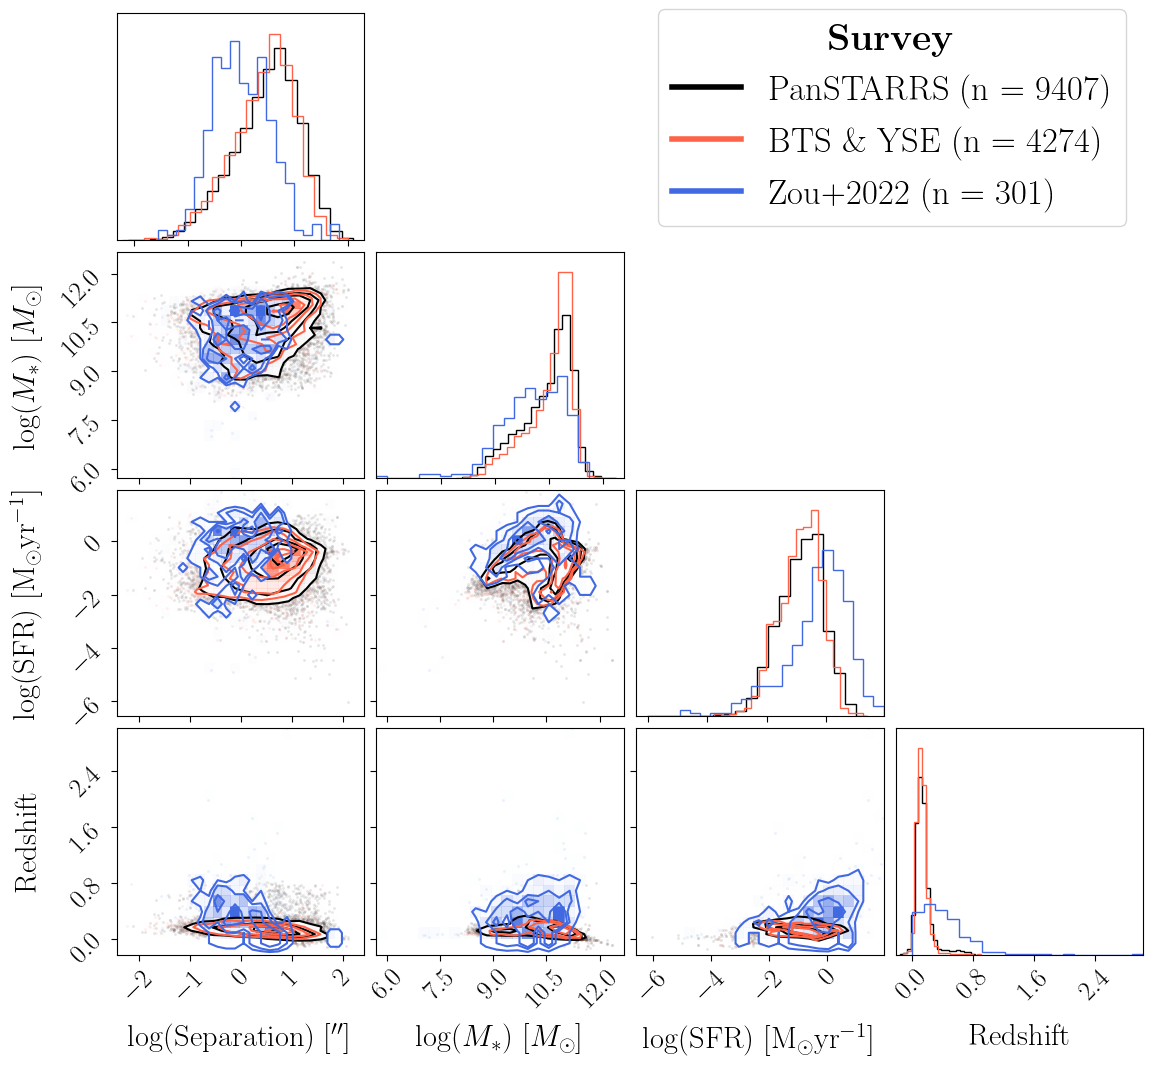

In [23]:
survey_cols = {'PanSTARRS': 'black', r'BTS \& YSE': 'tomato', 'Zou+2022': 'royalblue'}
label_kwargs = {'fontsize': 22, 'labelpad': -100}  # Adjust the labelpad as needed
survey_arrs = [pstar_props, bts_yse_props, zou_props]

numeric_columns = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
fig, axes = plt.subplots(4, 4, figsize=(12, 11))
fig = corner(pstar_props, color=survey_cols[f'PanSTARRS'], hist_kwargs=dict(density=True), fig=fig, labels=numeric_columns, label_kwargs=label_kwargs)
corner(bts_yse_props, fig=fig, color=survey_cols[f'BTS \& YSE'], hist_kwargs=dict(density=True))
corner(zou_props, fig=fig, color=survey_cols[f'Zou+2022'], hist_kwargs=dict(density=True))
legend_elements = [plt.Line2D([0], [0], color=col, lw=4, label=f'{survey_name} (n = {len(survey_arr)})') for (survey_name, col), survey_arr in zip(survey_cols.items(), survey_arrs)]

for ax in fig.axes:
    ax.xaxis.labelpad = -50
    ax.yaxis.labelpad = -50
    ax.tick_params(axis='both', which='major', labelsize=19, length=4)

plt.legend(handles=legend_elements, fontsize='25', bbox_to_anchor=(1, 4.245), frameon=True, title=r'\textbf{Survey}', title_fontsize='27', facecolor='white', loc='upper right')
plt.savefig('Figures/all_survey_corner.pdf', bbox_inches='tight')
plt.show()

In [24]:
zou_df.head()

,gal_id,host_ra,host_dec,SN_ra,SN_dec,SN_class,G,G_err,R,R_err,...,SPIRE350_err,SPIRE500,SPIRE500_err,log_Mstar_best,log_Mstar_best_err,log_SFR_best,log_SFR_best_err,redshift,redshift_err,angular_separation_arcsec
0,793720,53.502701,-28.660248,192609.75,-103176.8,Ia,0.000709,0.000083,0.000768,0.000155,...,0.000049,0.000076,0.000046,9.136305,0.229359,-1.395027,1.212359,0.612,0.1585,0.095110
1,1387864,53.267826,-26.964813,191760.15,-97073.5,Ic,1.890661,0.171436,2.359364,0.213790,...,768648.315996,0.784934,0.072928,9.792891,0.130438,0.329521,0.066791,0.060,0.0100,3.590571
2,776283,54.172970,-27.840040,195021.00,-100224.0,Ia,0.003090,0.000283,0.003418,0.000330,...,0.000100,0.001962,0.000187,8.377576,0.136285,-0.975580,0.154471,0.219,0.0100,1.502568
3,806358,53.526012,-27.632126,192693.30,-99475.6,"Ia,Ia-91T",0.181993,0.016444,0.179727,0.016241,...,0.008449,0.070639,0.006514,10.261489,0.097379,-2.026393,1.087790,0.148,0.0100,0.309975
4,1176629,53.912155,-28.319046,194081.25,-101949.6,Ia,0.027983,0.002538,0.034696,0.003164,...,0.001710,0.006656,0.000626,10.256422,0.133721,0.147166,0.192132,0.382,0.0100,2.438545


In [25]:
yse_df.head()

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift
0,105680495984702575,49.59846978,-1.93150966,1,15.2191,14.6927,14.4365,14.2971,14.0556,0.000873,0.000578,0.000541,0.000856,0.001856,0.2379643,49.599161,-1.930453,NaN,NaN
1,166991338952753243,133.89546417,49.16054004,1,20.0062,19.9385,19.5204,19.5922,19.7011,0.022047,0.022569,0.017368,0.038479,0.07546,0.00291667,133.897475,49.160259,SNII,0.135
2,97511471771729646,147.17717694,-8.73396483,1,16.398,15.7183,15.3767,15.1736,15.0371,0.001966,0.00128,0.00119,0.001611,0.004119,0.05865476,147.176208,-8.734392,SNIa-norm,0.053
3,134121777761851193,177.77617479,21.76720964,1,17.6355,16.9783,16.646,16.4204,16.3375,0.005596,0.004884,0.004178,0.005598,0.010297,0.06754167,177.772596,21.767258,SNIa-norm,0.059
4,107180511698942668,51.16988789,-0.68145459,1,15.3756,14.751,14.4013,14.1579,13.956,0.001651,0.001218,0.00101,0.001473,0.002739,0.1713155,51.172538,-0.681409,SNII,0.022


In [26]:
bts_df.head()

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID
0,126681757766820931,175.77662082,15.56701789,1,16.0256,15.2881,14.9533,14.7114,14.5005,0.002978,0.001497,0.001272,0.001197,0.002235,0.1110298,175.776542,15.567139,NaN,NaN,NaN
1,148231465149294617,146.51493972,33.52836114,1,18.2387,17.9746,17.875,17.8532,17.7821,0.004157,0.004871,0.004281,0.014407,0.019814,0.021125,146.514792,33.528250,SN II,0.03800,ZTF18aacemcn
2,153731349546771375,134.95471695,38.10897029,1,18.7478,19.0585,18.6466,18.8301,18.6221,0.006392,0.009475,0.004919,0.017235,0.038667,0.01741071,134.954667,38.109056,SN II,0.07247,ZTF18aacnlxz
3,169101206490177628,120.64903126,50.9224606,1,16.5325,15.6522,15.2551,15.0064,14.7582,0.002335,0.002128,0.000867,0.001623,0.003512,0.07590476,120.648958,50.922528,SN Ia,0.05295,ZTF18aadlaxo
4,159661026075384557,102.60753619,43.05326583,1,nan,14.2309,13.166,12.9816,12.8047,nan,0.000836,0.000408,0.001003,0.001687,0.1546488,102.607542,43.053222,SN IIn,0.01885,ZTF18aadmssd


In [27]:
panstarr_df.head()

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,angular_separation_arcsec
0,1.839010e+17,101.257336,63.249727,1.0,20.2123,19.4741,19.6845,19.6740,19.7830,0.024837,0.018832,0.023490,0.041619,0.093262,0.000000,101.257000,63.249972,II P,NaN,1.036981
1,8.326343e+16,343.097793,-20.610464,1.0,16.2329,15.8255,15.6137,15.5744,15.3857,0.002976,0.003105,0.002050,0.004439,0.007104,0.132961,343.097708,-20.614917,Ia,0.033150,16.031356
2,1.479104e+17,35.504167,33.266051,1.0,12.5022,11.7593,11.3363,11.3089,11.2106,0.000230,0.000150,0.000121,0.000202,0.000387,0.236131,35.499917,33.270472,Ia,0.013269,20.419790
3,1.072924e+17,244.140958,-0.588824,1.0,16.1156,15.7253,15.5693,15.4091,15.2103,0.001789,0.001106,0.001281,0.002573,0.004224,0.038113,244.141917,-0.590944,Ia,0.016460,8.378815
4,1.134624e+17,244.296033,4.554083,1.0,15.6716,14.9574,14.5674,14.3897,14.2283,0.001545,0.001123,0.000734,0.001367,0.002459,0.155941,244.295875,4.554083,Ia,0.018000,0.565643


In [28]:
test_df = pd.concat((bts_df, yse_df, panstarr_df)).sample(frac=1, random_state=22).reset_index(drop=True)
test_df.head()

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID,angular_separation_arcsec
0,102210721468816923,72.14689428,-4.81953917,1,15.228,14.5864,14.2948,14.0255,13.8162,0.001505,...,0.000701,0.001276,0.002629,0.2862678,72.147583,-4.822139,SN II,0.01500,ZTF20aagjpmt,NaN
1,111033132282605376.0,313.228254,2.52909,1.0,21.0277,20.49,20.0486,20.099,19.8563,0.042176,...,0.016004,0.048858,0.091115,0.004583,313.228054,2.528781,Ia,NaN,NaN,1.325783
2,174211421641392321,142.16420417,55.17638581,1,15.7754,15.1137,14.5681,14.3605,14.248,0.0054,...,0.00099,0.001579,0.002539,0.1358988,142.164500,55.176556,SN Ia,0.04830,ZTF20aagloch,NaN
3,199802397452155339,239.74539929,76.50375921,1,nan,20.7732,20.6296,20.3249,nan,nan,...,0.065349,0.083148,nan,0.0045,239.745625,76.503639,SN Ib,0.03000,ZTF23aaspcfl,NaN
4,103310817476296768.0,81.74762,-3.903068,1.0,16.7678,16.0987,15.6812,15.3686,15.1141,0.003065,...,0.002112,0.002547,0.004435,0.057,81.748858,-3.901833,Ia,0.03508,NaN,6.287947


In [29]:
test_df['angular_separation_arcsec'] = test_df.apply(lambda row: get_angular_separation(row['raStack_3pi'], row['decStack_3pi'], row['SN_ra'], row['SN_dec'], unit1='deg', unit2='deg'), axis=1)
test_df[test_df['angular_separation_arcsec'] > 10]

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID,angular_separation_arcsec
8,103460266639404352.0,26.663837,-3.780103,1.0,16.4435,16.0755,15.8953,15.6136,15.9165,0.004195,...,0.003379,0.00714,0.011254,0.668149,26.656600,-3.770081,II,0.017859,NaN,44.470450
25,173052901265004384.0,290.126486,54.211413,1.0,15.3053,14.452,14.0648,13.7484,13.5626,0.001924,...,0.000718,0.001317,0.002189,0.141149,290.120208,54.208517,Ia,0.044571,NaN,16.834521
30,90680727028837728.0,72.70283,-14.427211,1.0,NaN,20.1649,19.7628,19.0667,NaN,NaN,...,0.018666,0.019798,NaN,0.023554,72.702542,-14.423000,Ia,0.070000,NaN,15.194332
32,154221929692337184.0,192.969266,38.522121,1.0,17.7266,17.1796,16.7978,16.6634,16.5268,0.006185,...,0.003277,0.007199,0.008657,0.024833,192.967667,38.524917,Ia,0.160000,NaN,11.026054
36,164131939221585774,193.92212535,46.77927786,1,15.4755,14.8237,14.4024,14.225,14.1063,0.001942,...,0.00077,0.001222,0.002429,0.2185655,193.926250,46.781417,SN Ia,0.050100,ZTF19aadooun,12.754657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14294,140823461176589488.0,346.117646,27.357413,1.0,14.7213,13.9336,13.3885,13.1262,12.8319,0.001187,...,0.000507,0.000846,0.001281,0.184149,346.119083,27.353589,Ia,0.025660,NaN,14.514818
14296,85213329206893184.0,332.920686,-18.989293,1.0,18.8526,18.2064,17.8107,17.7506,17.4864,0.009869,...,0.005949,0.012243,0.028547,0.00125,332.920500,-18.994808,II,0.051400,NaN,19.865798
14298,130462312604609728.0,231.260457,18.72435,1.0,NaN,19.1833,18.6655,18.3428,17.9658,NaN,...,0.006496,0.007769,0.014448,0.006667,231.250000,18.730000,LGRB,NaN,NaN,41.047017
14302,119082159417884272.0,215.941745,9.236475,1.0,18.3639,15.3158,15.1893,14.9504,14.8984,0.005556,...,0.001721,0.002338,0.003981,0.141804,215.944133,9.234597,II,0.029895,NaN,10.848196


In [30]:
test_df[test_df['angular_separation_arcsec'] > 10][['SN_ra', 'SN_dec', 'raStack_3pi', 'decStack_3pi', 'ZTFID', 'objID_3pi', 'sn_class', 'angular_separation_arcsec']].head(10)

,SN_ra,SN_dec,raStack_3pi,decStack_3pi,ZTFID,objID_3pi,sn_class,angular_separation_arcsec
8,26.656600,-3.770081,26.663837,-3.780103,NaN,103460266639404352.0,II,44.470450
25,290.120208,54.208517,290.126486,54.211413,NaN,173052901265004384.0,Ia,16.834521
30,72.702542,-14.423000,72.70283,-14.427211,NaN,90680727028837728.0,Ia,15.194332
32,192.967667,38.524917,192.969266,38.522121,NaN,154221929692337184.0,Ia,11.026054
36,193.926250,46.781417,193.92212535,46.77927786,ZTF19aadooun,164131939221585774,SN Ia,12.754657
44,239.548667,19.765167,239.55502414,19.76671999,ZTF18abmjvpb,131722395549620610,SN Ia,22.252528
47,9.436062,-5.206228,9.440176,-5.204656,NaN,101750094401584864.0,II,15.793630
48,331.791333,6.485750,331.785614,6.486209,NaN,115783317856353888.0,Ic,20.523776
57,252.178000,35.949278,252.1754184,35.9425648,ZTF23aailjjs,151132521755421864,SN II,25.310874
60,110.422417,55.672917,110.4351597,55.67922622,ZTF21acbmxgn,174811104351705786,SN Ia,34.424890


In [31]:
test_df.keys()

Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'sn_class', 'sn_redshift', 'ZTFID', 'angular_separation_arcsec'],
      dtype='object')